<a href="https://colab.research.google.com/github/liuhuiaren0524/Kaggle_compet/blob/main/BERT_DisasterTwitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)
from google.colab import drive
drive.mount('/content/drive')

2.6.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git
!pip3 install tensorflow_text>=2.0.0rc0

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1388 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 25.17 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [6]:
!pip3 install sentencepiece

     |████████████████████████████████| 1.2 MB 4.1 MB/s 


In [7]:
!pip install tf-models-official

     |████████████████████████████████| 1.8 MB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 17.8 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 211 kB 46.3 MB/s 
     |████████████████████████████████| 37.1 MB 49 kB/s 
     |████████████████████████████████| 99 kB 10.0 MB/s 
     |████████████████████████████████| 352 kB 47.1 MB/s 
     |████████████████████████████████| 90 kB 9.6 MB/s 
     |████████████████████████████████| 636 kB 49.1 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=7073b8943a12028239b4d030be656cd733b0b2e1eabbb91e46b768c42966ef40
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=bf172fae3eabd08873e33c41e58233816d3f29ea86b21b318aa468c956e29334
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b1

In [8]:
!pip install tensorflow_addons

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import sys
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [30]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# import data

In [31]:
df = pd.read_csv("/content/drive/MyDrive/app/Kaggle_competition/input_DisasterTwitter/nlp-getting-started/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


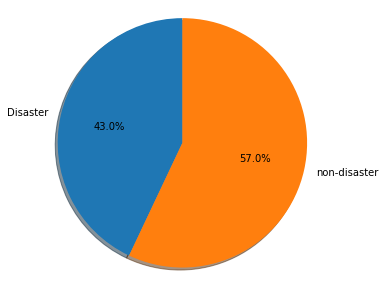

In [32]:
fig = plt.figure(figsize=(5,5))
all_disaster_tweets = df[df["target"] == 1]["text"].to_list()
all_non_disaster_tweets = df[df["target"] == 0]["text"].to_list()
labels = "Disaster", "non-disaster"

sizes = [len(all_disaster_tweets), len(all_non_disaster_tweets)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, 
        startangle=90)

plt.axis('equal')
plt.show()

# Split Train/test

In [33]:
train_df, valid_df = train_test_split(df, random_state=42, train_size=0.8, stratify=df.target.values)
train_df.shape, valid_df.shape

((6090, 5), (1523, 5))

In [34]:
train_data = tf.data.Dataset.from_tensor_slices((train_df.text.values, train_df.target.values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df.text.values, valid_df.target.values))

for text, label in train_data.take(1):
    print('\033[92m' + text.numpy().decode('utf-8'))
    print(label.numpy())

Sassy city girl country hunk stranded in Smoky Mountain snowstorm #AoMS http://t.co/nkKcTttsD9 #ibooklove #bookboost
1


**Download a Pre-trained BERT Model from TensorFlow Hub

In [35]:
label_list = [0, 1]
max_seq_length = 128

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [37]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

# Tokenize and Preprocess Text for BERT

In [38]:
def process_tweet(tweet):
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    return tweet  

In [24]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
    example = classifier_data_lib.InputExample(guid=None, 
                                             text_a = process_tweet(text.numpy().decode("utf-8")),
                                             text_b = None,
                                             label = label.numpy())
  
    feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                                       max_seq_length, tokenizer)
  
    return feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id

# Wrap a Python Function into a TensorFlow op for Eager Execution¶


In [25]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature,
                                                                inp=[text, label],
                                                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

    input_ids.set_shape([max_seq_length])  
    input_mask.set_shape([max_seq_length])  
    segment_ids.set_shape([max_seq_length])  
    label_id.set_shape([])

    X = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }  

    return X, label_id

# Create a TensorFlow input Pipeline

In [39]:
train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
.shuffle(1000)
.batch(32, drop_remainder=True)
.prefetch(tf.data.experimental.AUTOTUNE))

valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
.batch(32, drop_remainder=True)
.prefetch(tf.data.experimental.AUTOTUNE))

In [40]:
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

# Create Model

In [ ]:
def create_model():
    input_word_ids = keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_word_ids")
    input_mask = keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_mask")
    input_type_ids = keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_type_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    drop = tf.keras.layers.Dropout(0.5)(pooled_output)
    output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

    model = tf.keras.Model(
        inputs={
            "input_word_ids": input_word_ids,
            "input_mask": input_mask,
            "input_type_ids": input_type_ids
        },
        outputs = output)
    
    return model

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

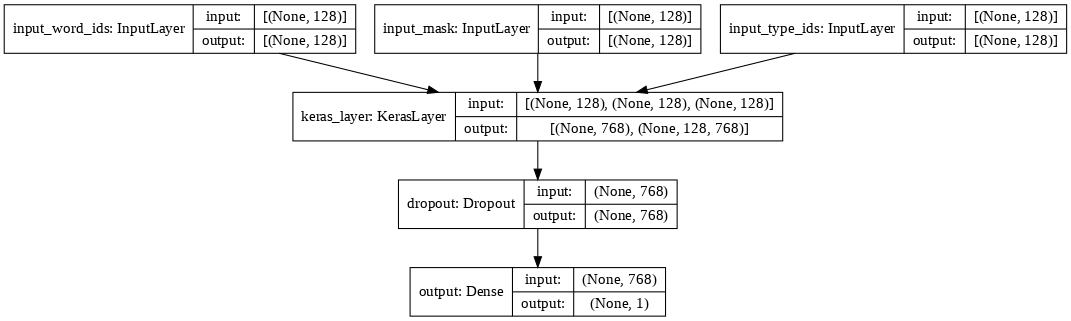

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

**Train Model**

In [41]:
with tf.device('/gpu:0'):
    epochs = 20
    history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose = 1)

NameError: ignored

# Evaluate visually the model

In [27]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [28]:
plot_graphs(history, 'loss')

NameError: ignored

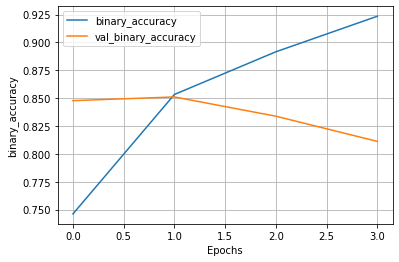

In [ ]:
plot_graphs(history, 'binary_accuracy')

# Test predict

In [26]:
test_df = pd.read_csv("/content/drive/MyDrive/app/Kaggle_competition/input_DisasterTwitter/nlp-getting-started/test.csv")
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_df.text.values, np.zeros(test_df.shape[0])))
test_data = (test_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
.batch(32, drop_remainder=False)
.prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
y_pred = model.predict(test_data)

In [ ]:
target_pred = [1 if y[0] >= 0.5 else 0 for y in y_pred.tolist()]

In [ ]:
submission_df = test_df.drop(["keyword", "location", "text"], axis=1)
submission_df["target"] = target_pred
submission_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
submission_df.to_csv("/content/drive/MyDrive/app/Kaggle_competition/input_DisasterTwitter/nlp-getting-started/submission.csv", index=False)